This notebook examines different methods of cross-correlation to see if there is an offset in the wavelength calibration of different exposures which, if corrected, would boost the S/N of some lines in the swift data. The largest offset found was 10 pixels and most were between 0-5.

In [2]:
import os
import glob
import numpy as np
from astropy.io import fits
from astropy.modeling import models, fitting
from matplotlib import pyplot
%matplotlib inline


In [22]:
DATA_DIR = '../data/swiftuvot/reduced/00034040001/uvot/image'
FIG_DIR = '../figures/'

# Create Cross-Covariance Function

In [11]:
def calc_ccvf(arr1, arr2, lag=None):
    '''
    Calculate the cross-covariance matrix defined as
    CCVF[lag] = 1/(N-1) SUM_(i=1)^(N)((arr1[i-lag]-mean(arr1))(arr2[i]-mean(arr2))
    
    arr1 and arr2 are assumed to have the same sampling interval
    lag can either be an array of integer lags to calculate the CCVF
    for or if None, the the CCVF is calculated for all possible lags.
    Small number statistics may govern the edge values
    
    The mean of each array is computed for each lag using the overlapping
    points only
    
    '''
    
    if lag is None:
        lag = np.arange(-arr1.size+2, arr2.size-1, 1)
        print('setting lag to ', lag)
    else:
        lag = np.array(lag)
        
    arr1_pad = np.zeros(2*arr1.size+arr2.size-2)
    arr1_pad_indx = np.arange(2*arr1.size+arr2.size-2)-arr1.size+1
    assert (lag >= -arr1.size+2).all(), 'Lag is too negative'
    assert (lag < arr2.size-1).all(), 'Lag is too big'
    CCVF = []
    for ilag in lag:
        arr1_pad[(arr1_pad_indx>=0+ilag) & (arr1_pad_indx <= arr1.size+ilag-1)] = arr1
        arr_min = max(0, ilag)
        arr_max = min(arr2.size-1, arr1.size-1+ilag)
        arr2_overlap = arr2[arr_min:arr_max+1]
        arr1_overlap = arr1_pad[(arr1_pad_indx>=arr_min)&(arr1_pad_indx <=arr_max)]
        assert len(arr2_overlap) == len(arr1_overlap), 'Something is wrong, overlap regions are different sizes'
        #Use the mean of the overlap rather than the mean of the whole series b/c mean and
        #std will vary with wavelength 
        tmp_ccvf = 1./len(arr2_overlap)* \
                   np.sum((arr1_overlap - np.mean(arr1_overlap))*
                          (arr2_overlap - np.mean(arr2_overlap)))
        CCVF.append(tmp_ccvf)
        #print(arr1_overlap)
        #print(arr2_overlap)
    return lag, np.array(CCVF)

It might be problematic not dividing by the standard deviation b/c a CCVF calculated from very few points should have more noise, and therefore be weighted less, while a CCVF calulated from more points should have less noise, and therefore be weighted more????

In [12]:
arr1 = np.array([1, 0, 1])
arr2 = np.array([1,2,1,0,1])
lag_ccvf, CCVF = calc_ccvf(arr1,arr2)
print(CCVF)

('setting lag to ', array([-1,  0,  1,  2,  3]))
[ 0.25       -0.22222222  0.          0.22222222 -0.25      ]


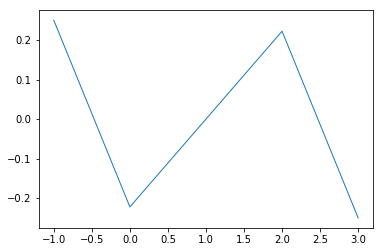

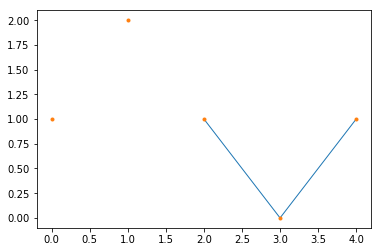

In [13]:
pix1 = np.arange(arr1.size)
pix2 = np.arange(arr2.size)
pyplot.plot(lag_ccvf, CCVF)
pyplot.figure()
pyplot.plot(pix1+lag_ccvf[3], arr1)
pyplot.plot(pix2,arr2, 'o')


# Create a Chi Square Function

In [14]:
def reduced_chisq(arr1, arr2, err1, err2):
    '''
    calculated the reduced chi square of two sets of data
    Since chi-square is usually data-model, and I have data-data,
    I've assumed arr2 is the "model" and arr1 is the "data".
    However, to account for the total uncertainty in a given point,
    I've added the error of arr2 in quadrature with the error in arr1
    and treated that as the total error. I am assuming the number of
    degrees of freedom is just the size of one array, not the size of
    both arrays. This code requires that both arrays be the same size.

    '''
    err = np.sqrt(err1**2 + err2**2)
    chisq = np.sum((arr1 - arr2)**2/(err)**2)
    reduced_chisq = chisq/arr1.size
    return reduced_chisq

In [15]:
def calc_reduced_chisq(arr1, arr2, arr1_err, arr2_err, lag=None):
    '''
    Calculate the reduced chi-sq of two sets of data. arr1 is offset from arr2 and the 
    reduced chi-square is calculated from the overlapping region
    
    arr1 and arr2 are assumed to have the same sampling interval
    lag can either be an array of integer lags
    or if None, the the reduced chi-square is calculated for all possible lags.
    Small number statistics may govern the edge values
    
    '''
    
    if lag is None:
        lag = np.arange(-arr1.size+2, arr2.size-1, 1)
        print('setting lag to ', lag)
    else:
        lag = np.array(lag)
        
    arr1_pad = np.zeros(2*arr1.size+arr2.size-2)
    arr1_err_pad = np.zeros(2*arr1.size+arr2.size-2)
    arr1_pad_indx = np.arange(2*arr1.size+arr2.size-2)-arr1.size+1
    assert (lag >= -arr1.size+2).all(), 'Lag is too negative'
    assert (lag < arr2.size-1).all(), 'Lag is too big'
    reduced_chisq_arr = []
    for ilag in lag:
        arr1_pad[(arr1_pad_indx>=0+ilag) & (arr1_pad_indx <= arr1.size+ilag-1)] = arr1
        arr1_err_pad[(arr1_pad_indx>=0+ilag) & (arr1_pad_indx <= arr1.size+ilag-1)] = arr1_err
        arr_min = max(0, ilag)
        arr_max = min(arr2.size-1, arr1.size-1+ilag)
        arr2_overlap = arr2[arr_min:arr_max+1]
        arr2_err_overlap = arr2_err[arr_min:arr_max+1]
        arr1_overlap = arr1_pad[(arr1_pad_indx>=arr_min)&(arr1_pad_indx <=arr_max)]
        arr1_err_overlap = arr1_err_pad[(arr1_pad_indx>=arr_min)&(arr1_pad_indx <=arr_max)]
        assert len(arr2_overlap) == len(arr1_overlap), 'Something is wrong, overlap regions are different sizes'

        tmp_reduced_chisq = reduced_chisq(arr1_overlap, arr2_overlap, arr1_err_overlap, arr2_err_overlap)
        reduced_chisq_arr.append(tmp_reduced_chisq)
        #print(arr1_overlap)
        #print(arr2_overlap)
    return lag, np.array(reduced_chisq_arr)

In [16]:
arr1 = np.array([1, 0, 1])
arr2 = np.array([1,2,1,0,1])
arr1_err = np.ones(arr1.size)*0.1
arr2_err = np.ones(arr2.size)*0.1

lag_chi, chi = calc_reduced_chisq(arr1, arr2, arr1_err, arr2_err, lag=None)

('setting lag to ', array([-1,  0,  1,  2,  3]))


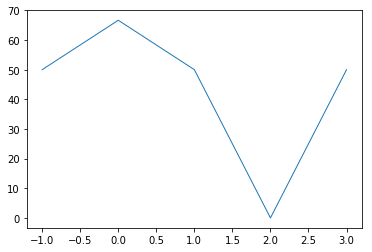

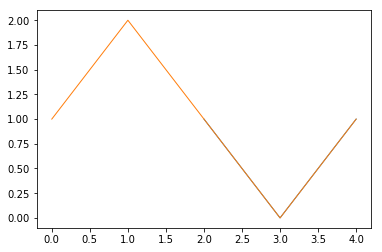

In [17]:
pyplot.plot(lag_chi, chi)
pyplot.figure()
pix1 = np.arange(arr1.size)+lag_chi[np.argmin(chi)]
pix2 = np.arange(arr2.size)
pyplot.plot(pix1, arr1)
pyplot.plot(pix2, arr2)

## Compare Lags for 2 different methods:

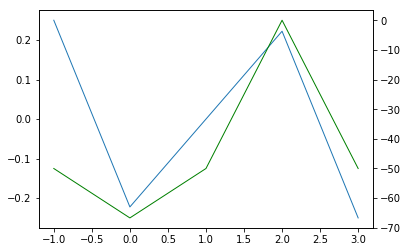

In [18]:
pyplot.plot(lag_ccvf, CCVF)
pyplot.twinx()
pyplot.plot(lag_chi, -chi, 'g')

('setting lag to ', array([-3, -2, -1,  0,  1]))
('setting lag to ', array([-3, -2, -1,  0,  1]))


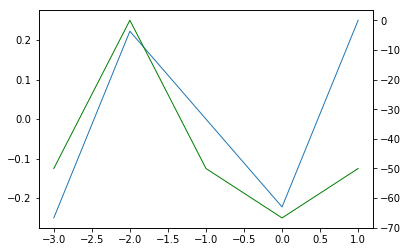

In [19]:
lag_ccvf, CCVF = calc_ccvf(arr2,arr1)
lag_chi, chi = calc_reduced_chisq(arr2, arr1, arr2_err, arr1_err, lag=None)
pyplot.plot(lag_ccvf, CCVF)
pyplot.twinx()
pyplot.plot(lag_chi, -chi, 'g')

# Try using Numpy's correlate with mode = valid

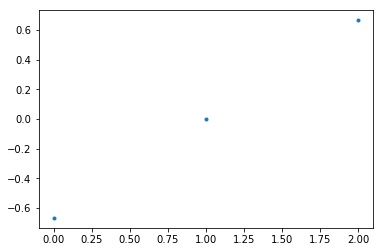

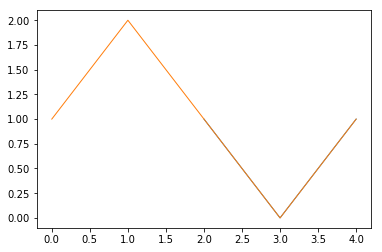

In [20]:
arr1 = np.array([1, 0, 1])
arr2 = np.array([1,2,1,0,1])
corr = np.correlate( arr2-np.mean(arr2),arr1-np.mean(arr1), mode='valid')
pyplot.plot(corr, 'o')
pyplot.figure()
pix1 = np.arange(arr1.size)+np.argmax(corr)
pix2 = np.arange(arr2.size)
pyplot.plot(pix1, arr1)
pyplot.plot(pix2, arr2)

In [21]:
def correlate_valid(arr1, arr2, offset):
    ccf = np.correlate(arr1, arr2, mode='valid')
    lag = np.arange(np.abs(arr1.size - arr2.size+1)) - offset
    return lag, ccf

# Check for drift in Visit 01

(1600, 3000)

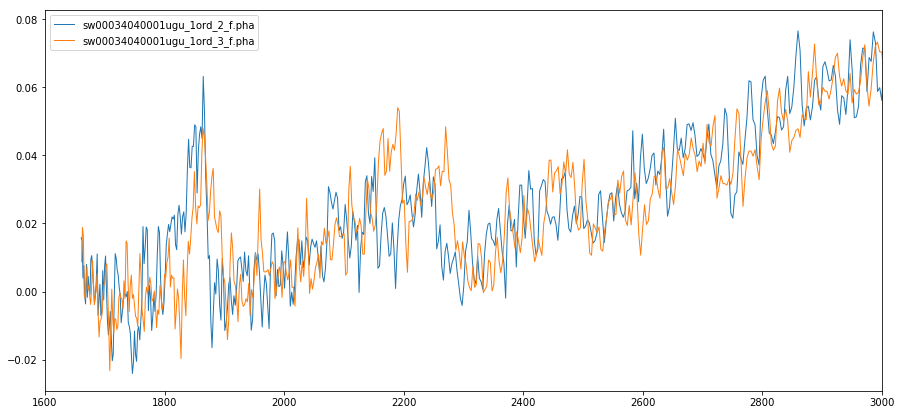

In [23]:
fig = pyplot.figure(figsize=[15, 7])
ax1 = fig.add_subplot(1,1,1)
flist = glob.glob(os.path.join(DATA_DIR, '*pha*'))
for ifile in flist[1:]:
    tbdata = fits.getdata(ifile, 2)
    pyplot.plot(tbdata['lambda'], tbdata['netrate'], label=os.path.basename(ifile))
ax1.legend(loc='best')
ax1.set_xlim(1600, 3000)

# Test Autocorrelation

In [24]:
tbdata1 = fits.getdata(os.path.join(DATA_DIR, 'sw00034040001ugu_1ord_1_f.pha'), 2)
tbdata3 = fits.getdata(os.path.join(DATA_DIR, 'sw00034040001ugu_1ord_3_f.pha'), 2)
tbdata2 = fits.getdata(os.path.join(DATA_DIR, 'sw00034040001ugu_1ord_2_f.pha'), 2)

### CCVF 

In [25]:
lag_ccvf, CCVF = calc_ccvf(tbdata1['netrate'], tbdata1['netrate'], lag=np.arange(-100, 100))

### Reduced Chi Square 

In [26]:
netrate1_err = np.sqrt(1/fits.getval(os.path.join(DATA_DIR, 'sw00034040001ugu_1ord_1_f.pha'), 'exposure', 2)**2 * \
                       np.abs(tbdata1['netrate']))
netrate3_err = np.sqrt(1/fits.getval(os.path.join(DATA_DIR, 'sw00034040001ugu_1ord_3_f.pha'), 'exposure', 2)**2 * \
                       np.abs(tbdata3['netrate']))
netrate2_err = np.sqrt(1/fits.getval(os.path.join(DATA_DIR, 'sw00034040001ugu_1ord_2_f.pha'), 'exposure', 2)**2 * \
                       np.abs(tbdata2['netrate']))


lag_chi, chi = calc_reduced_chisq(tbdata1['netrate'], tbdata1['netrate'], netrate1_err, netrate1_err, 
                                  lag=np.arange(-100, 100))

### Np.correlate 

In [27]:
netrate1 = tbdata1['netrate'][100:-100]
lag_np, ccf = correlate_valid(tbdata1['netrate'], netrate1, 100)

In [28]:
print(lag_ccvf[np.argmax(CCVF)])
print(lag_chi[np.argmin(chi)])
print(lag_np[np.argmax(ccf)])

0
0
0


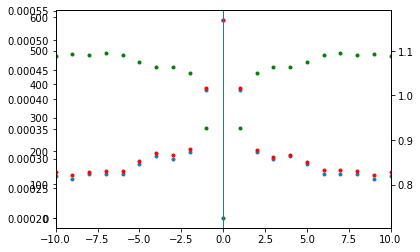

In [29]:
pyplot.plot(lag_ccvf, CCVF, 'o')
pyplot.twinx()
pyplot.plot(lag_chi, chi, 'go')
pyplot.twinx()
pyplot.plot(np.arange(-100, 101), ccf, 'ro')
pyplot.xlim(-10, 10)
pyplot.axvline(0)

# Test on Different Exposures 

In [30]:
tbdata1 = fits.getdata(os.path.join(DATA_DIR, 'sw00034040001ugu_1ord_1_f.pha'), 2)
tbdata3 = fits.getdata(os.path.join(DATA_DIR, 'sw00034040001ugu_1ord_3_f.pha'), 2)

### CCVF 

In [31]:
lag_ccvf, CCVF = calc_ccvf(tbdata1['netrate'], tbdata3['netrate'], lag=np.arange(-100, 100))

### Reduced Chi Square 

In [32]:
netrate1_err = np.sqrt(1/fits.getval(os.path.join(DATA_DIR, 'sw00034040001ugu_1ord_1_f.pha'), 'exposure', 2)**2 * \
                       np.abs(tbdata1['netrate']))
netrate3_err = np.sqrt(1/fits.getval(os.path.join(DATA_DIR, 'sw00034040001ugu_1ord_3_f.pha'), 'exposure', 2)**2 * \
                       np.abs(tbdata3['netrate']))

lag_chi, chi = calc_reduced_chisq(tbdata1['netrate'], tbdata3['netrate'], netrate1_err, netrate3_err, 
                                  lag=np.arange(-100, 100))

### Np.correlate 

In [33]:
netrate1 = tbdata1['netrate'][100:-100]
lag_np, ccf = correlate_valid(tbdata3['netrate'], netrate1, 100)

In [34]:
print(lag_ccvf[np.argmax(CCVF)])
print(lag_chi[np.argmin(chi)])
print(lag_np[np.argmax(ccf)])

-1
-2
-1


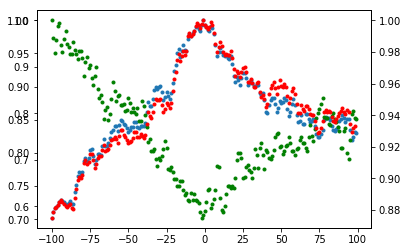

In [35]:
pyplot.plot(lag_ccvf, CCVF/CCVF.max(), 'o')
pyplot.twinx()
pyplot.plot(lag_chi, chi/chi.max(), 'go')
pyplot.twinx()
pyplot.plot(lag_np, ccf/ccf.max(), 'ro')


## Exposure 2 and 3

In [36]:
tbdata2 = fits.getdata(os.path.join(DATA_DIR, 'sw00034040001ugu_1ord_2_f.pha'), 2)
tbdata3 = fits.getdata(os.path.join(DATA_DIR, 'sw00034040001ugu_1ord_3_f.pha'), 2)

### CCVF 

In [37]:
lag_ccvf, CCVF = calc_ccvf(tbdata2['netrate'], tbdata3['netrate'], lag=np.arange(-100, 100))

### Reduced Chi Square 

In [38]:
netrate2_err = np.sqrt(1/fits.getval(os.path.join(DATA_DIR, 'sw00034040001ugu_1ord_2_f.pha'), 'exposure', 2)**2 * \
                       np.abs(tbdata2['netrate']))

netrate3_err = np.sqrt(1/fits.getval(os.path.join(DATA_DIR, 'sw00034040001ugu_1ord_3_f.pha'), 'exposure', 2)**2 * \
                       np.abs(tbdata3['netrate']))
lag_chi, chi = calc_reduced_chisq(tbdata1['netrate'], tbdata3['netrate'], netrate1_err, netrate3_err, 
                                  lag=np.arange(-100, 100))

### Np.correlate 

In [39]:
netrate2 = tbdata2['netrate'][100:-100]
lag_np, ccf = correlate_valid(tbdata3['netrate'], netrate2, 100)

In [40]:
print(lag_ccvf[np.argmax(CCVF)])
print(lag_chi[np.argmin(chi)])
print(lag_np[np.argmax(ccf)])

10
-2
10


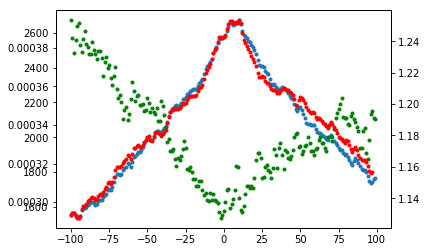

In [41]:
pyplot.plot(lag_ccvf, CCVF, 'o')
pyplot.twinx()
pyplot.plot(lag_chi, chi, 'go')
pyplot.twinx()
pyplot.plot(lag_np, ccf, 'ro')


# Investigate how inclusion of first bump affects offsets

(0, 800)

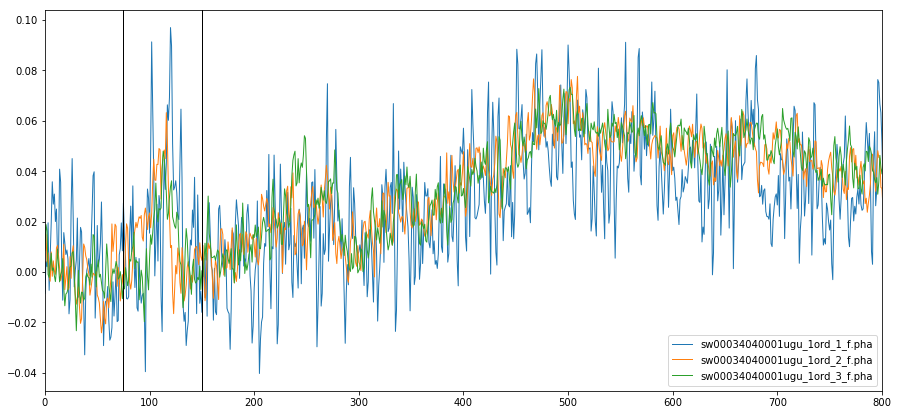

In [42]:
fig = pyplot.figure(figsize=[15, 7])
ax1 = fig.add_subplot(1,1,1)
flist = glob.glob(os.path.join(DATA_DIR, '*pha*'))
for ifile in flist:
    tbdata = fits.getdata(ifile, 2)
    pyplot.plot(np.arange(tbdata['netrate'].size), tbdata['netrate'], label=os.path.basename(ifile))
ax1.legend(loc='best')
pyplot.axvline(75, color='k')
pyplot.axvline(150, color='k')
ax1.set_xlim(0, 800)

## Include first "emission" feature

In [43]:
lag_ccvf1, ccvf1 = calc_ccvf(tbdata1['netrate'], tbdata3['netrate'], lag=np.arange(-100, 100))
lag_chi1, chi1 = calc_reduced_chisq(tbdata1['netrate'], tbdata3['netrate'], netrate1_err, netrate3_err, 
                                  lag=np.arange(-100, 100))
lag_ccf1, ccf1 = correlate_valid(tbdata3['netrate'], tbdata1['netrate'][100:-100], 100)
lag_ccvf2, ccvf2 = calc_ccvf(tbdata2['netrate'], tbdata3['netrate'], lag=np.arange(-100, 100))
lag_chi2, chi2 = calc_reduced_chisq(tbdata2['netrate'], tbdata3['netrate'], netrate2_err, netrate3_err, 
                                  lag=np.arange(-100, 100))
lag_ccf2, ccf2 = correlate_valid(tbdata3['netrate'], tbdata2['netrate'][100:-100], 100)

In [44]:
print('exposure 1 shift to 3 by:')
print('\tccvf shift = {}'.format(lag_ccvf1[np.argmax(ccvf1)]))
print('\tchi shift = {}'.format(lag_chi1[np.argmin(chi1)]))
print('\tccf shift = {}'.format(lag_ccf1[np.argmax(ccf1)]))
print('exposure 2 shift to 3 by:')
print('\tccvf shift = {}'.format(lag_ccvf2[np.argmax(ccvf2)]))
print('\tchi shift = {}'.format(lag_chi2[np.argmin(chi2)]))
print('\tccf shift = {}'.format(lag_ccf2[np.argmax(ccf2)]))

exposure 1 shift to 3 by:
	ccvf shift = -1
	chi shift = -2
	ccf shift = -1
exposure 2 shift to 3 by:
	ccvf shift = 10
	chi shift = 10
	ccf shift = 10


## Exclude first "emission" feature

In [45]:
lag_ccvf1, ccvf1 = calc_ccvf(tbdata1['netrate'][150:], tbdata3['netrate'][150:], lag=np.arange(-100, 100))
lag_chi1, chi1 = calc_reduced_chisq(tbdata1['netrate'][150:], tbdata3['netrate'][150:], 
                                    netrate1_err[150:], netrate3_err[150:], 
                                    lag=np.arange(-100, 100))
lag_ccf1, ccf1 = correlate_valid(tbdata3['netrate'], tbdata1['netrate'][150:-100], 150)
lag_ccvf2, ccvf2 = calc_ccvf(tbdata2['netrate'][150:], tbdata3['netrate'][150:], lag=np.arange(-150, 100))
lag_chi2, chi2 = calc_reduced_chisq(tbdata2['netrate'][150:], tbdata3['netrate'][150:], 
                                    netrate2_err[150:], netrate3_err[150:], 
                                    lag=np.arange(-100, 100))
lag_ccf2, ccf2 = correlate_valid(tbdata3['netrate'], tbdata2['netrate'][150:-100], 150)

In [46]:
print('exposure 1 shift to 3 by:')
print('\tccvf shift = {}'.format(lag_ccvf1[np.argmax(ccvf1)]))
print('\tchi shift = {}'.format(lag_chi1[np.argmin(chi1)]))
print('\tccf shift = {}'.format(lag_ccf1[np.argmax(ccf1)]))
print('exposure 2 shift to 3 by:')
print('\tccvf shift = {}'.format(lag_ccvf2[np.argmax(ccvf2)]))
print('\tchi shift = {}'.format(lag_chi2[np.argmin(chi2)]))
print('\tccf shift = {}'.format(lag_ccf2[np.argmax(ccf2)]))

exposure 1 shift to 3 by:
	ccvf shift = 4
	chi shift = -2
	ccf shift = 4
exposure 2 shift to 3 by:
	ccvf shift = 10
	chi shift = 10
	ccf shift = 10


## Exclude first "emission" feature and wl > 5000

In [47]:
lag_ccvf1, ccvf1 = calc_ccvf(tbdata1['netrate'][150:800], tbdata3['netrate'][150:800], lag=np.arange(-100, 100))
lag_chi1, chi1 = calc_reduced_chisq(tbdata1['netrate'][150:800], tbdata3['netrate'][150:800], 
                                    netrate1_err[150:800], netrate3_err[150:800], 
                                    lag=np.arange(-100, 100))
lag_ccf1, ccf1 = correlate_valid(tbdata3['netrate'], tbdata1['netrate'][150:800], 150)
lag_ccvf2, ccvf2 = calc_ccvf(tbdata2['netrate'][150:800], tbdata3['netrate'][150:800], lag=np.arange(-100, 100))
lag_chi2, chi2 = calc_reduced_chisq(tbdata2['netrate'][150:800], tbdata3['netrate'][150:800], 
                                    netrate2_err[150:800], netrate3_err[150:800], 
                                    lag=np.arange(-100, 100))
lag_ccf2, ccf2 = correlate_valid(tbdata3['netrate'], tbdata2['netrate'][150:800], 150)

In [48]:
print('exposure 1 shift to 3 by:')
print('\tccvf shift = {}'.format(lag_ccvf1[np.argmax(ccvf1)]))
print('\tchi shift = {}'.format(lag_chi1[np.argmin(chi1)]))
print('\tccf shift = {}'.format(lag_ccf1[np.argmax(ccf1)]))
print('exposure 2 shift to 3 by:')
print('\tccvf shift = {}'.format(lag_ccvf2[np.argmax(ccvf2)]))
print('\tchi shift = {}'.format(lag_chi2[np.argmin(chi2)]))
print('\tccf shift = {}'.format(lag_ccf2[np.argmax(ccf2)]))

exposure 1 shift to 3 by:
	ccvf shift = -1
	chi shift = -2
	ccf shift = 4
exposure 2 shift to 3 by:
	ccvf shift = 10
	chi shift = 7
	ccf shift = 11


### No Shift 

(150, 800)

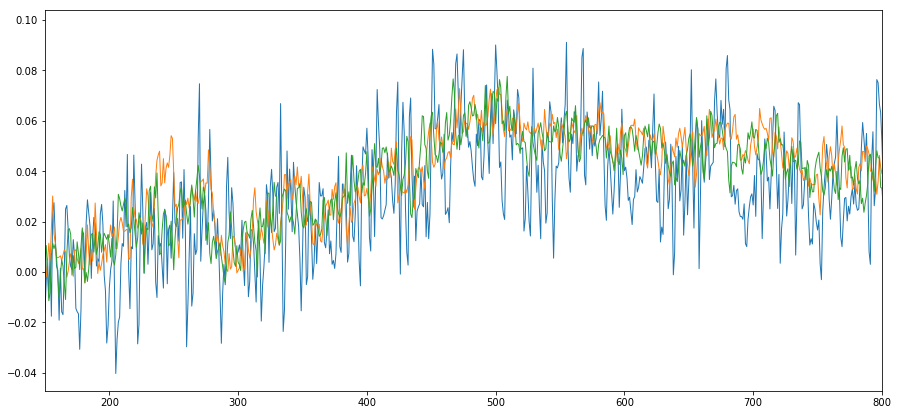

In [49]:
fig = pyplot.figure(figsize=[15, 7])
ax1 = fig.add_subplot(1,1,1)
flist = glob.glob(os.path.join(DATA_DIR, '*pha*'))
ax1.plot(np.arange(tbdata1['netrate'].size), tbdata1['netrate'],label=os.path.basename(flist[0]))
ax1.plot(np.arange(tbdata3['netrate'].size), tbdata3['netrate'], label=os.path.basename(flist[2]))
ax1.plot(np.arange(tbdata2['netrate'].size), tbdata2['netrate'],label=os.path.basename(flist[1]))
ax1.set_xlim(150, 800)

### Cross-Correlation shift

(150, 800)

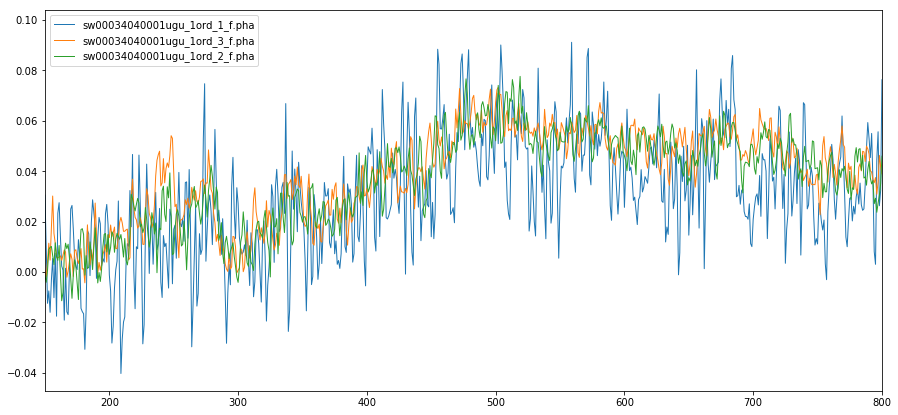

In [50]:
fig = pyplot.figure(figsize=[15, 7])
ax1 = fig.add_subplot(1,1,1)
flist = glob.glob(os.path.join(DATA_DIR, '*pha*'))
tbdata1 = fits.getdata(flist[0], 2)
tbdata2 = fits.getdata(flist[1], 2)
tbdata3 = fits.getdata(flist[2], 2)
ax1.plot(np.arange(tbdata1['netrate'].size)+4, tbdata1['netrate'],label=os.path.basename(flist[0]))
ax1.plot(np.arange(tbdata3['netrate'].size), tbdata3['netrate'], label=os.path.basename(flist[2]))
ax1.plot(np.arange(tbdata2['netrate'].size)+10, tbdata2['netrate'],label=os.path.basename(flist[1]))
ax1.legend(loc='best')
ax1.set_xlim(150,800)

### Reduced Chi Sq shift

(150, 800)

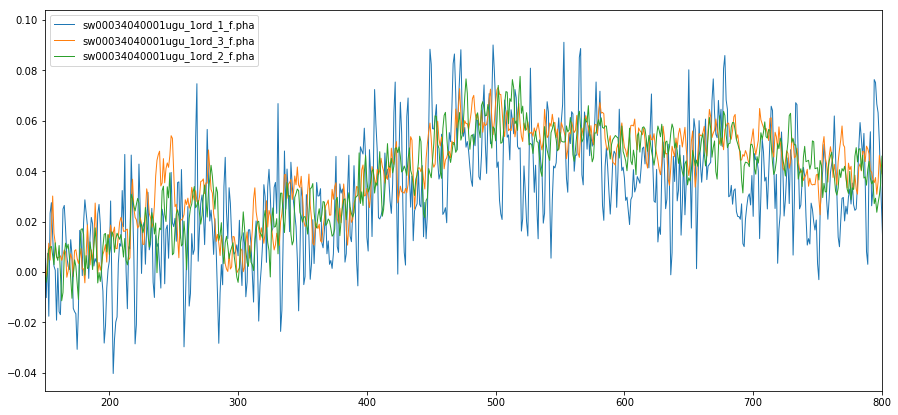

In [51]:
fig = pyplot.figure(figsize=[15, 7])
ax1 = fig.add_subplot(1,1,1)
flist = glob.glob(os.path.join(DATA_DIR, '*pha*'))
tbdata1 = fits.getdata(flist[0], 2)
tbdata2 = fits.getdata(flist[1], 2)
tbdata3 = fits.getdata(flist[2], 2)
ax1.plot(np.arange(tbdata1['netrate'].size)-2, tbdata1['netrate'],label=os.path.basename(flist[0]))
ax1.plot(np.arange(tbdata3['netrate'].size), tbdata3['netrate'], label=os.path.basename(flist[2]))
ax1.plot(np.arange(tbdata2['netrate'].size)+10, tbdata2['netrate'],label=os.path.basename(flist[1]))
ax1.legend(loc='best')
ax1.set_xlim(150,800)

### Make sure I'm shifting the right direction

('setting lag to ', array([-8, -7, -6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6]))


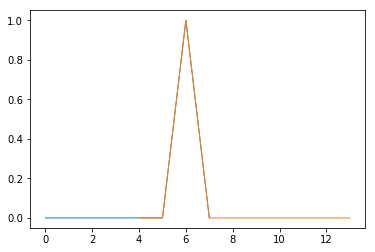

In [52]:
x = np.zeros(10)
x[2] = 1
y = np.zeros(8)
y[6] = 1

lag, ccvf = calc_ccvf(x, y)
pyplot.plot(np.arange(y.size), y)
pyplot.plot(np.arange(x.size)+lag[np.argmax(ccvf)], x)

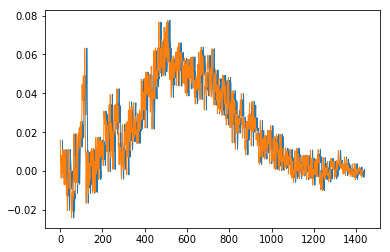

In [53]:
pyplot.plot(np.arange(tbdata2['netrate'].size)+10, tbdata2['netrate'],label=os.path.basename(flist[1]))
pyplot.plot(np.arange(tbdata2['netrate'].size), tbdata2['netrate'],label=os.path.basename(flist[1]))

# Look at combined spectra using different offsets

In [54]:
tbdata_no_offset = fits.getdata(os.path.join(DATA_DIR, '00034040001_x1dsum.fits'), 1)
tbdata_chi_offset = fits.getdata(os.path.join(DATA_DIR, 'shift_wl_chi', 'sum_chi_offset.fits'), 1)
tbdata_ccf_offset = fits.getdata(os.path.join(DATA_DIR, 'shift_wl_ccf', 'sum_ccf_offset.fits'), 1)

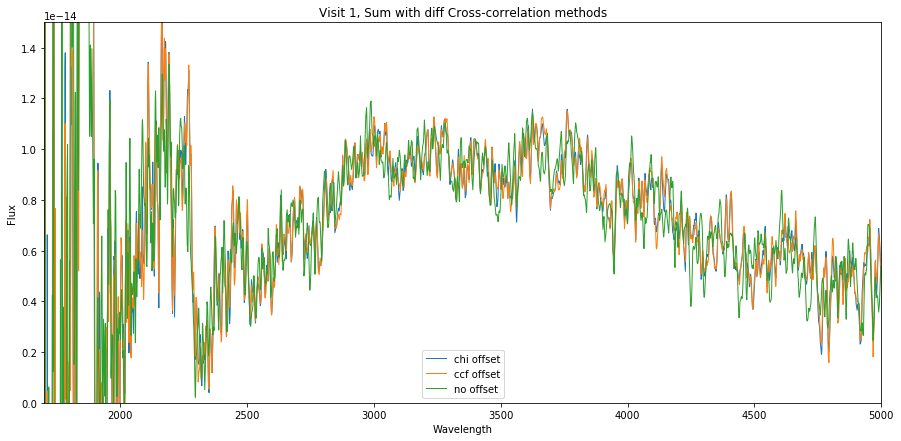

In [74]:
fig = pyplot.figure(figsize=[15, 7])
ax1 = fig.add_subplot(1,1,1)
ax1.plot(tbdata_chi_offset['wave'], tbdata_chi_offset['flux'], label='chi offset')
ax1.plot(tbdata_ccf_offset['wave'], tbdata_ccf_offset['flux'], label='ccf offset')
ax1.plot(tbdata_no_offset['wave'], tbdata_no_offset['flux'], label='no offset')
ax1.set_ylim(-0E-14, 1.5E-14)
ax1.set_xlim(1700, 5000)
ax1.legend(loc='best')
ax1.set_title('Visit 1, Sum with diff Cross-correlation methods')
ax1.set_xlabel('Wavelength')
ax1.set_ylabel('Flux')
pyplot.savefig(os.path.join(FIG_DIR, 'cross_corr_comp_v1.pdf'))

I'm not seeing many returns from the cross-correlating

* apply to ther spectra?
* consider other wl ranges

# Combine Visits 5 and 9 (PA=248, 9/10 and 9/11)

In [56]:
tbdata1 = fits.getdata(os.path.join(DATA_DIR.replace('00034040001', '00034040005'),
                                    'sw00034040005ugu_1ord_1_f.pha'), 2)
tbdata2 = fits.getdata(os.path.join(DATA_DIR.replace('00034040001', '00034040005'),
                                    'sw00034040005ugu_1ord_2_f.pha'), 2)
tbdata3 = fits.getdata(os.path.join(DATA_DIR.replace('00034040001', '00034040005'),
                                    'sw00034040005ugu_1ord_3_f.pha'), 2)
tbdata4 = fits.getdata(os.path.join(DATA_DIR.replace('00034040001', '00034040009'),
                                    'sw00034040009ugu_1ord_1_f.pha'), 2)
tbdata5 = fits.getdata(os.path.join(DATA_DIR.replace('00034040001', '00034040009'),
                                    'sw00034040009ugu_1ord_2_f.pha'), 2)

In [57]:
netrate1_err = np.sqrt(1/fits.getval(os.path.join(
                                     DATA_DIR.replace('00034040001', '00034040005'), 
                                     'sw00034040005ugu_1ord_1_f.pha'), 
                                     'exposure', 2)**2 * \
                       np.abs(tbdata1['netrate']))
netrate2_err = np.sqrt(1/fits.getval(os.path.join(
                                     DATA_DIR.replace('00034040001', '00034040005'), 
                                     'sw00034040005ugu_1ord_2_f.pha'), 
                                     'exposure', 2)**2 * \
                       np.abs(tbdata2['netrate']))
netrate3_err = np.sqrt(1/fits.getval(os.path.join(
                                     DATA_DIR.replace('00034040001', '00034040005'), 
                                     'sw00034040005ugu_1ord_3_f.pha'), 
                                     'exposure', 2)**2 * \
                       np.abs(tbdata3['netrate']))
netrate4_err = np.sqrt(1/fits.getval(os.path.join(
                                     DATA_DIR.replace('00034040001', '00034040009'), 
                                     'sw00034040009ugu_1ord_1_f.pha'), 
                                     'exposure', 2)**2 * \
                       np.abs(tbdata4['netrate']))
netrate5_err = np.sqrt(1/fits.getval(os.path.join(
                                     DATA_DIR.replace('00034040001', '00034040009'), 
                                     'sw00034040009ugu_1ord_1_f.pha'), 
                                     'exposure', 2)**2 * \
                       np.abs(tbdata5['netrate']))


In [58]:
lag_ccvf2, ccvf2 = calc_ccvf(tbdata2['netrate'][150:800], tbdata1['netrate'][150:800], 
                             lag=np.arange(-100, 100))
lag_chi2, chi2 = calc_reduced_chisq(tbdata2['netrate'][150:800], tbdata1['netrate'][150:800],
                                    netrate2_err[150:800], netrate1_err[150:800], 
                                    lag=np.arange(-100, 100))
lag_ccf2, ccf2 = correlate_valid(tbdata1['netrate'], tbdata2['netrate'][150:800], 150)

In [59]:
lag_ccvf3, ccvf3 = calc_ccvf(tbdata3['netrate'][150:800], tbdata1['netrate'][150:800], 
                             lag=np.arange(-100, 100))
lag_chi3, chi3 = calc_reduced_chisq(tbdata3['netrate'][150:800], tbdata1['netrate'][150:800],
                                    netrate3_err[150:800], netrate1_err[150:800], 
                                    lag=np.arange(-100, 100))
lag_ccf3, ccf3 = correlate_valid(tbdata1['netrate'], tbdata3['netrate'][150:800], 150)

In [60]:
lag_ccvf4, ccvf4 = calc_ccvf(tbdata4['netrate'][150:800], tbdata1['netrate'][150:800], 
                             lag=np.arange(-100, 100))
lag_chi4, chi4 = calc_reduced_chisq(tbdata4['netrate'][150:800], tbdata1['netrate'][150:800],
                                    netrate4_err[150:800], netrate1_err[150:800], 
                                    lag=np.arange(-100, 100))
lag_ccf4, ccf4 = correlate_valid(tbdata1['netrate'], tbdata4['netrate'][150:800], 150)

In [61]:
lag_ccvf5, ccvf5 = calc_ccvf(tbdata5['netrate'][150:800], tbdata1['netrate'][150:800], 
                             lag=np.arange(-100, 100))
lag_chi5, chi5 = calc_reduced_chisq(tbdata5['netrate'][150:800], tbdata1['netrate'][150:800],
                                    netrate5_err[150:800], netrate1_err[150:800], 
                                    lag=np.arange(-100, 100))
lag_ccf5, ccf5 = correlate_valid(tbdata1['netrate'], tbdata5['netrate'][150:800], 150)

In [62]:
print('exposure 5.2 shift to 5.1 by:')
print('\tccvf shift = {}'.format(lag_ccvf2[np.argmax(ccvf2)]))
print('\tchi shift = {}'.format(lag_chi2[np.argmin(chi2)]))
print('\tccf shift = {}'.format(lag_ccf2[np.argmax(ccf2)]))

print('exposure 5.3 shift to 5.1 by:')
print('\tccvf shift = {}'.format(lag_ccvf3[np.argmax(ccvf3)]))
print('\tchi shift = {}'.format(lag_chi3[np.argmin(chi3)]))
print('\tccf shift = {}'.format(lag_ccf3[np.argmax(ccf3)]))

print('exposure 9.1 shift to 5.1 by:')
print('\tccvf shift = {}'.format(lag_ccvf4[np.argmax(ccvf4)]))
print('\tchi shift = {}'.format(lag_chi4[np.argmin(chi4)]))
print('\tccf shift = {}'.format(lag_ccf4[np.argmax(ccf4)]))

print('exposure 9.2 shift to 5.1 by:')
print('\tccvf shift = {}'.format(lag_ccvf5[np.argmax(ccvf5)]))
print('\tchi shift = {}'.format(lag_chi5[np.argmin(chi5)]))
print('\tccf shift = {}'.format(lag_ccf5[np.argmax(ccf5)]))

exposure 5.2 shift to 5.1 by:
	ccvf shift = -1
	chi shift = 0
	ccf shift = 0
exposure 5.3 shift to 5.1 by:
	ccvf shift = 2
	chi shift = 5
	ccf shift = 6
exposure 9.1 shift to 5.1 by:
	ccvf shift = 0
	chi shift = 1
	ccf shift = 0
exposure 9.2 shift to 5.1 by:
	ccvf shift = 1
	chi shift = 3
	ccf shift = 1


# Create Directories and Shift Visits 5 and 9

In [63]:
import shutil
import glob

base_dir5 = '../data/swiftuvot/reduced/00034040005/uvot/image/'
ccf_dir = 'shift_wl_ccf'
chi_dir = 'shift_wl_chi'

try:
    os.mkdir(os.path.join(base_dir5, chi_dir))
except:
    pass
try:
    os.mkdir(os.path.join(base_dir5, ccf_dir))
except:
    pass

flist5 = glob.glob(os.path.join(base_dir5, '*pha'))
for ifile in flist5:
    shutil.copyfile(ifile, os.path.join(base_dir5, ccf_dir, os.path.basename(ifile)))
    shutil.copyfile(ifile, os.path.join(base_dir5, chi_dir, os.path.basename(ifile)))

In [64]:
base_dir9 = '../data/swiftuvot/reduced/00034040009/uvot/image/'
ccf_dir = 'shift_wl_ccf'
chi_dir = 'shift_wl_chi'

try:
    os.mkdir(os.path.join(base_dir9, chi_dir))
except:
    pass
try:
    os.mkdir(os.path.join(base_dir9, ccf_dir))
except:
    pass

flist9 = glob.glob(os.path.join(base_dir9, '*pha'))
for ifile in flist9:
    shutil.copyfile(ifile, os.path.join(base_dir9, ccf_dir, os.path.basename(ifile)))
    shutil.copyfile(ifile, os.path.join(base_dir9, chi_dir, os.path.basename(ifile)))

In [65]:
import sys
sys.path.append('/Users/bostroem/Desktop/research/asassn15oz/code')

In [66]:
from apply_pix_shift_swift_grism import apply_pixel_shift

In [68]:
###Only execute this once

apply_pixel_shift(os.path.join(base_dir5, chi_dir, 
                               os.path.basename(flist5[2])), 
                  5)
apply_pixel_shift(os.path.join(base_dir5, ccf_dir, 
                               os.path.basename(flist5[2])), 
                  6)

In [69]:
###Only execute this once
apply_pixel_shift(os.path.join(base_dir9, chi_dir, 
                               os.path.basename(flist9[0])), 
                  1)

In [76]:
###Only execute this once
apply_pixel_shift(os.path.join(base_dir9, chi_dir, 
                               os.path.basename(flist9[1])), 
                  1)
apply_pixel_shift(os.path.join(base_dir9, ccf_dir, 
                               os.path.basename(flist9[1])), 
                  3)

['../data/swiftuvot/reduced/00034040005/uvot/image/sw00034040005ugu_1ord_1_f.pha', '../data/swiftuvot/reduced/00034040005/uvot/image/sw00034040005ugu_1ord_2_f.pha', '../data/swiftuvot/reduced/00034040005/uvot/image/sw00034040005ugu_1ord_3_f.pha']


In [70]:
from uvotpy.uvotspec import sum_PHAspectra

In [78]:
all_files_chi = []
all_files_ccf = []
all_files_no_offset = []
for ifile in flist5:
    all_files_chi.append(os.path.join(base_dir5, chi_dir,
                                     os.path.basename(ifile)))
    all_files_ccf.append(os.path.join(base_dir5, ccf_dir, 
                                     os.path.basename(ifile)))
    all_files_no_offset.append(os.path.join(base_dir5, 
                                            os.path.basename(ifile)))
for ifile in flist9:
    all_files_chi.append(os.path.join(base_dir9, chi_dir,
                                     os.path.basename(ifile)))
    all_files_ccf.append(os.path.join(base_dir9, ccf_dir, 
                                     os.path.basename(ifile)))
    all_files_no_offset.append(os.path.join(base_dir9, 
                                           os.path.basename(ifile)))


In [79]:
outfile_chi = os.path.join(base_dir5, chi_dir, 'sum_chi_offset.fits')
sum_PHAspectra(all_files_chi, outfile=outfile_chi)

outfile_ccf = os.path.join(base_dir5, ccf_dir, 'sum_ccf_offset.fits')
sum_PHAspectra(all_files_ccf, outfile=outfile_ccf)

outfile_no_offset = os.path.join(base_dir5, 'sum_v5_v9_no_offset.fits')
sum_PHAspectra(all_files_no_offset, outfile=outfile_no_offset)


 INPUT =============================================================================
sum_PHAspectra(
phafiles;['../data/swiftuvot/reduced/00034040005/uvot/image/shift_wl_chi/sw00034040005ugu_1ord_1_f.pha', '../data/swiftuvot/reduced/00034040005/uvot/image/shift_wl_chi/sw00034040005ugu_1ord_2_f.pha', '../data/swiftuvot/reduced/00034040005/uvot/image/shift_wl_chi/sw00034040005ugu_1ord_3_f.pha', '../data/swiftuvot/reduced/00034040009/uvot/image/shift_wl_chi/sw00034040009ugu_1ord_1_f.pha', '../data/swiftuvot/reduced/00034040009/uvot/image/shift_wl_chi/sw00034040009ugu_1ord_2_f.pha'],
wave_shifts=[0.0, 0.0, 0.0, 0.0, 0.0],
exclude_wave=[[[[1664.3733, 1679.4413], [1936.9015, 2026.3027]]], [[[1664.0358, 1680.4429], [1939.083, 2028.7223]]], [[[1670.538, 1675.5908], [1930.3983, 2021.573]]], [[[1665.2283, 1676.5239], [1934.665, 2023.9032]]], [[[1663.9791, 1695.1655], [1963.4623, 2055.2834]]]],
ignore_flags=False
interactive=False, outfile=../data/swiftuvot/reduced/00034040005/uvot/image/shift_w

outsub exclude_wave:  [[[[1664.3733, 1679.4413], [1936.9015, 2026.3027]]], [[[1664.0358, 1680.4429], [1939.083, 2028.7223]]], [[[1670.538, 1675.5908], [1930.3983, 2021.573]]], [[[1665.2283, 1676.5239], [1934.665, 2023.9032]]], [[[1663.9791, 1695.1655], [1963.4623, 2055.2834]]]]
writing fits file
outsub exclude_wave:  [[[[1664.3733, 1679.4413], [1936.9015, 2026.3027]]], [[[1664.0358, 1680.4429], [1939.083, 2028.7223]]], [[[1671.7906, 1676.8715], [1932.5757, 2023.9569]]], [[[1664.0328, 1675.2655], [1932.5066, 2021.5443]]], [[[1663.9791, 1695.1655], [1963.4623, 2055.2834]]]]
writing fits file
outsub exclude_wave:  [[[[1664.3733, 1679.4413], [1936.9015, 2026.3027]]], [[[1664.0358, 1680.4429], [1939.083, 2028.7223]]], [[[1664.4022, 1669.3148], [1919.6158, 2009.7517]]], [[[1664.0328, 1675.2655], [1932.5066, 2021.5443]]], [[[1663.9791, 1695.1655], [1963.4623, 2055.2834]]]]
writing fits file



 INPUT =============================================================================
sum_PHAspectra(
phafiles;['../data/swiftuvot/reduced/00034040005/uvot/image/sw00034040005ugu_1ord_1_f.pha', '../data/swiftuvot/reduced/00034040005/uvot/image/sw00034040005ugu_1ord_2_f.pha', '../data/swiftuvot/reduced/00034040005/uvot/image/sw00034040005ugu_1ord_3_f.pha', '../data/swiftuvot/reduced/00034040009/uvot/image/sw00034040009ugu_1ord_1_f.pha', '../data/swiftuvot/reduced/00034040009/uvot/image/sw00034040009ugu_1ord_2_f.pha'],
wave_shifts=[0.0, 0.0, 0.0, 0.0, 0.0],
exclude_wave=[[[[1664.3733, 1679.4413], [1936.9015, 2026.3027]]], [[[1664.0358, 1680.4429], [1939.083, 2028.7223]]], [[[1664.4022, 1669.3148], [1919.6158, 2009.7517]]], [[[1664.0328, 1675.2655], [1932.5066, 2021.5443]]], [[[1663.9791, 1695.1655], [1963.4623, 2055.2834]]]],
ignore_flags=False
interactive=False, outfile=../data/swiftuvot/reduced/00034040005/uvot/image/sum_v5_v9_no_offset.fits, 
figno=14, chatter=1, clobber=True)
_sum_we

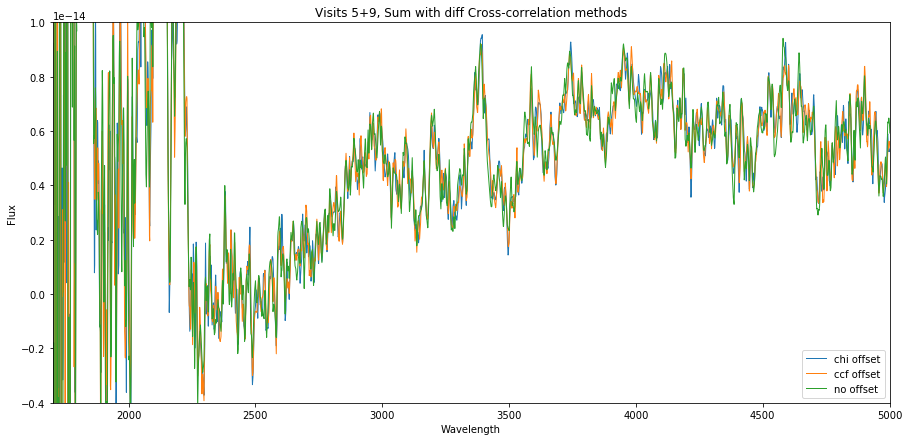

In [83]:
fig = pyplot.figure(figsize=[15, 7])
ax1 = fig.add_subplot(1,1,1)
tbdata_chi_offset = fits.getdata(outfile_chi, 1)
tbdata_ccf_offset = fits.getdata(outfile_ccf, 1)
tbdata_no_offset = fits.getdata(outfile_no_offset, 1)

ax1.plot(tbdata_chi_offset['wave'], tbdata_chi_offset['flux'], label='chi offset')
ax1.plot(tbdata_ccf_offset['wave'], tbdata_ccf_offset['flux'], label='ccf offset')
ax1.plot(tbdata_no_offset['wave'], tbdata_no_offset['flux'], label='no offset')
ax1.set_ylim(-0.4E-14, 1E-14)
ax1.set_xlim(1700, 5000)
ax1.legend(loc='best')
ax1.set_title('Visits 5+9, Sum with diff Cross-correlation methods')
ax1.set_xlabel('Wavelength')
ax1.set_ylabel('Flux')
pyplot.savefig(os.path.join(FIG_DIR, 'cross_corr_comp_v5_v9.pdf'))

## Conclusion: Cross-correlating to account for wavelength shifts does not enhance any signal